In [15]:
import os
import numpy as np
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

# load model

In [17]:
model_dir ='/media/tohn/SSD/ModelTrainByImages/R2_5/models/B5R2b5_15AB_1FC_fold5_2.h5' #แก้
model = load_model(model_dir)
height = width = model.input_shape[1]

In [18]:
# validation
import pandas as pd
base_dir  = '/media/tohn/SSD/Images/Image5/'#แก้
dataframe = pd.read_csv( '/home/yupaporn/codes/USAI/Validationdf_fold5_2.csv')#แก้
validation_dir = os.path.join(base_dir, 'validation')

#Train
train_df = pd.read_csv( '/home/yupaporn/codes/USAI/Traindf_fold5_2.csv')#แก้
base_dir0 = '/media/tohn/SSD/Images/Image5/'#แก้
os.chdir(base_dir0)
train_dir = os.path.join(base_dir0, 'train')

# Select Data

In [19]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/Validationdf_fold5_2.csv')
print(df0 .shape)
dataframe = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
print(dataframe.shape)
print('Normal: ',dataframe[dataframe['Class']=='Normal'].shape)
print('Abnormal: ',dataframe[dataframe['Class']=='Abnormal'].shape)
dataframe.head(5)

(1030, 21)
(1030, 21)
Normal:  (714, 21)
Abnormal:  (316, 21)


,Unnamed: 0,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,Views,fold,...,originalImage,left,top,width,height,Rleft,Rtop,Rwidth,Rheight,filename
0,0,42,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,https://irisprodseatraining.blob.core.windows....,231.0,134.0,544.0,380.0,0.229956,0.149621,0.541516,0.422222,AB02 P1 C042.JPG
1,1,42,P2,P2,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,https://irisprodseatraining.blob.core.windows....,238.0,140.0,497.0,549.0,0.237177,0.155682,0.494585,0.610101,AB02 P2 C042.JPG
2,2,42,P1,P1,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,https://irisprodseatraining.blob.core.windows....,229.0,98.0,645.0,550.0,0.228564,0.109217,0.643761,0.612121,AB04 P1 C042.JPG
3,3,42,P2,P2,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,https://irisprodseatraining.blob.core.windows....,202.0,123.0,516.0,547.0,0.203649,0.137500,0.519196,0.608081,AB04 P2 C042.JPG
4,4,42,P2,P2,Abnormal,AB06,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,https://irisprodseatraining.blob.core.windows....,278.0,98.0,446.0,434.0,0.284593,0.109217,0.456401,0.482828,AB06 P2 C042.JPG


In [20]:
batch_size = 64
epochs = 10

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = train_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_class',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k.replace("C","")) for k,v in labels.items())
print(labels)

Found 1030 validated image filenames belonging to 15 classes.
{0: 'AB01', 1: 'AB02', 2: 'AB03', 3: 'AB04', 4: 'AB05', 5: 'AB06', 6: 'AB07', 7: 'AB081', 8: 'AB082', 9: 'AB083', 10: 'AB09', 11: 'AB10', 12: 'AB11', 13: 'AB12', 14: 'Normal'}


# Prediction

In [21]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=dataframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

dataframe['category'] = pred_list
dataframe['Prob'] = prob_list

In [22]:
dataframe.head(5)

,Unnamed: 0,Case,Abs Position,Sub Position,Class,Sub_class,Path Full,Path Crop,Views,fold,...,top,width,height,Rleft,Rtop,Rwidth,Rheight,filename,category,Prob
0,0,42,P1,P1,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,134.0,544.0,380.0,0.229956,0.149621,0.541516,0.422222,AB02 P1 C042.JPG,AB02,0.984386
1,1,42,P2,P2,Abnormal,AB02,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,140.0,497.0,549.0,0.237177,0.155682,0.494585,0.610101,AB02 P2 C042.JPG,AB02,0.999377
2,2,42,P1,P1,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,98.0,645.0,550.0,0.228564,0.109217,0.643761,0.612121,AB04 P1 C042.JPG,AB04,0.998871
3,3,42,P2,P2,Abnormal,AB04,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,123.0,516.0,547.0,0.203649,0.137500,0.519196,0.608081,AB04 P2 C042.JPG,AB04,0.999994
4,4,42,P2,P2,Abnormal,AB06,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,7,...,98.0,446.0,434.0,0.284593,0.109217,0.456401,0.482828,AB06 P2 C042.JPG,Normal,0.701100


# Visualization

In [23]:
data_train = dataframe
#เช็คคลาสใน Predicted
pred_class = set(data_train['category'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['Sub_class'])
print('Actual : ',len(classe))
print(classe)

Predicted :  15
{'AB081', 'AB04', 'AB09', 'AB083', 'AB01', 'AB082', 'AB11', 'AB07', 'AB12', 'AB06', 'Normal', 'AB03', 'AB10', 'AB02', 'AB05'}
Actual :  15
{'AB081', 'AB04', 'AB09', 'AB083', 'AB082', 'AB11', 'AB07', 'Normal', 'AB12', 'AB06', 'AB01', 'AB03', 'AB10', 'AB02', 'AB05'}


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['Sub_class'].array
pred = data_train['category'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 89.12621359223301%
              precision    recall  f1-score   support

        AB01       0.85      0.53      0.66        43
        AB02       0.76      0.78      0.77        36
        AB03       0.62      0.50      0.55        16
        AB04       1.00      0.70      0.82        33
        AB05       1.00      0.58      0.73        19
        AB06       0.50      0.22      0.31         9
        AB07       0.50      0.36      0.42        11
       AB081       0.91      0.56      0.69        18
       AB082       0.74      0.82      0.78        17
       AB083       1.00      0.10      0.18        10
        AB09       0.89      0.57      0.70        14
        AB10       1.00      0.33      0.50         6
        AB11       0.92      0.55      0.69        22
        AB12       0.84      0.95      0.89        62
      Normal       0.91      1.00      0.95       714

    accuracy                           0.89      1030
   macro avg       0.83      0.57      

### Confusion matrix

Text(0.5, 21.5, 'Predicted label')

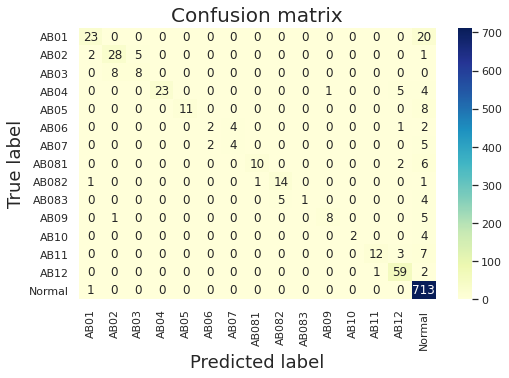

In [25]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [26]:
act= data_train['Sub_class'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
pred = data_train['category'].map({'AB12':1, 'AB04':1, 'AB05':1, 'Normal':0, 'AB02':1, 'AB11':1, 'AB082':1, 'AB06':1,'AB07':1, 'AB081':1, 'AB09':1, 'AB03':1, 'AB10':1, 'AB01':1, 'AB083':1}).values
cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 93.20388349514563%
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       714
           1       1.00      0.78      0.88       316

    accuracy                           0.93      1030
   macro avg       0.95      0.89      0.91      1030
weighted avg       0.94      0.93      0.93      1030



713 1 69 247


Text(0.5, 21.5, 'Predicted label')

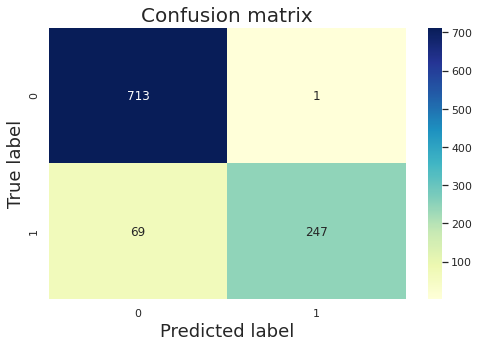

In [27]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)
TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
print(TN, FP, FN, TP)
#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

In [28]:
TN, FP, FN, TP = confusion_matrix(act, pred).ravel()
print(TN, FP, FN, TP)

713 1 69 247
